No GPU available, using the CPU instead.


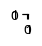

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

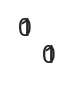

In [2]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [4]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [5]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

3480


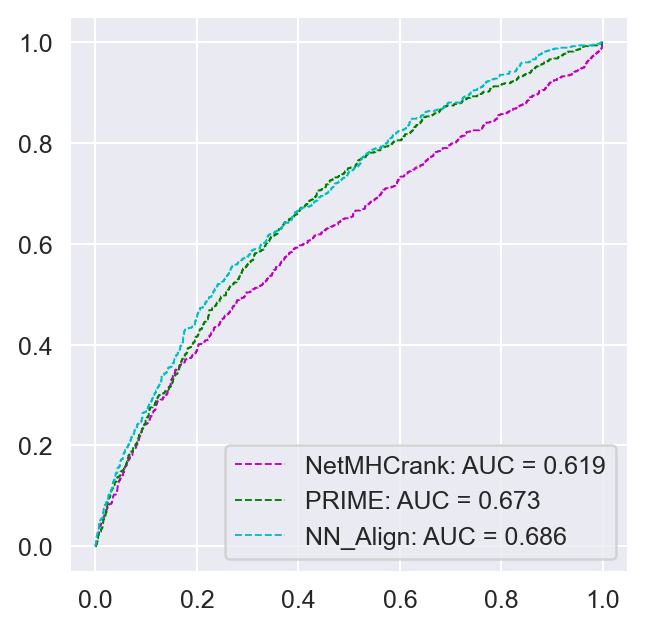

In [8]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

In [9]:
from src.baselines import plot_related_baseline_roc

In [10]:
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

(86, 94)

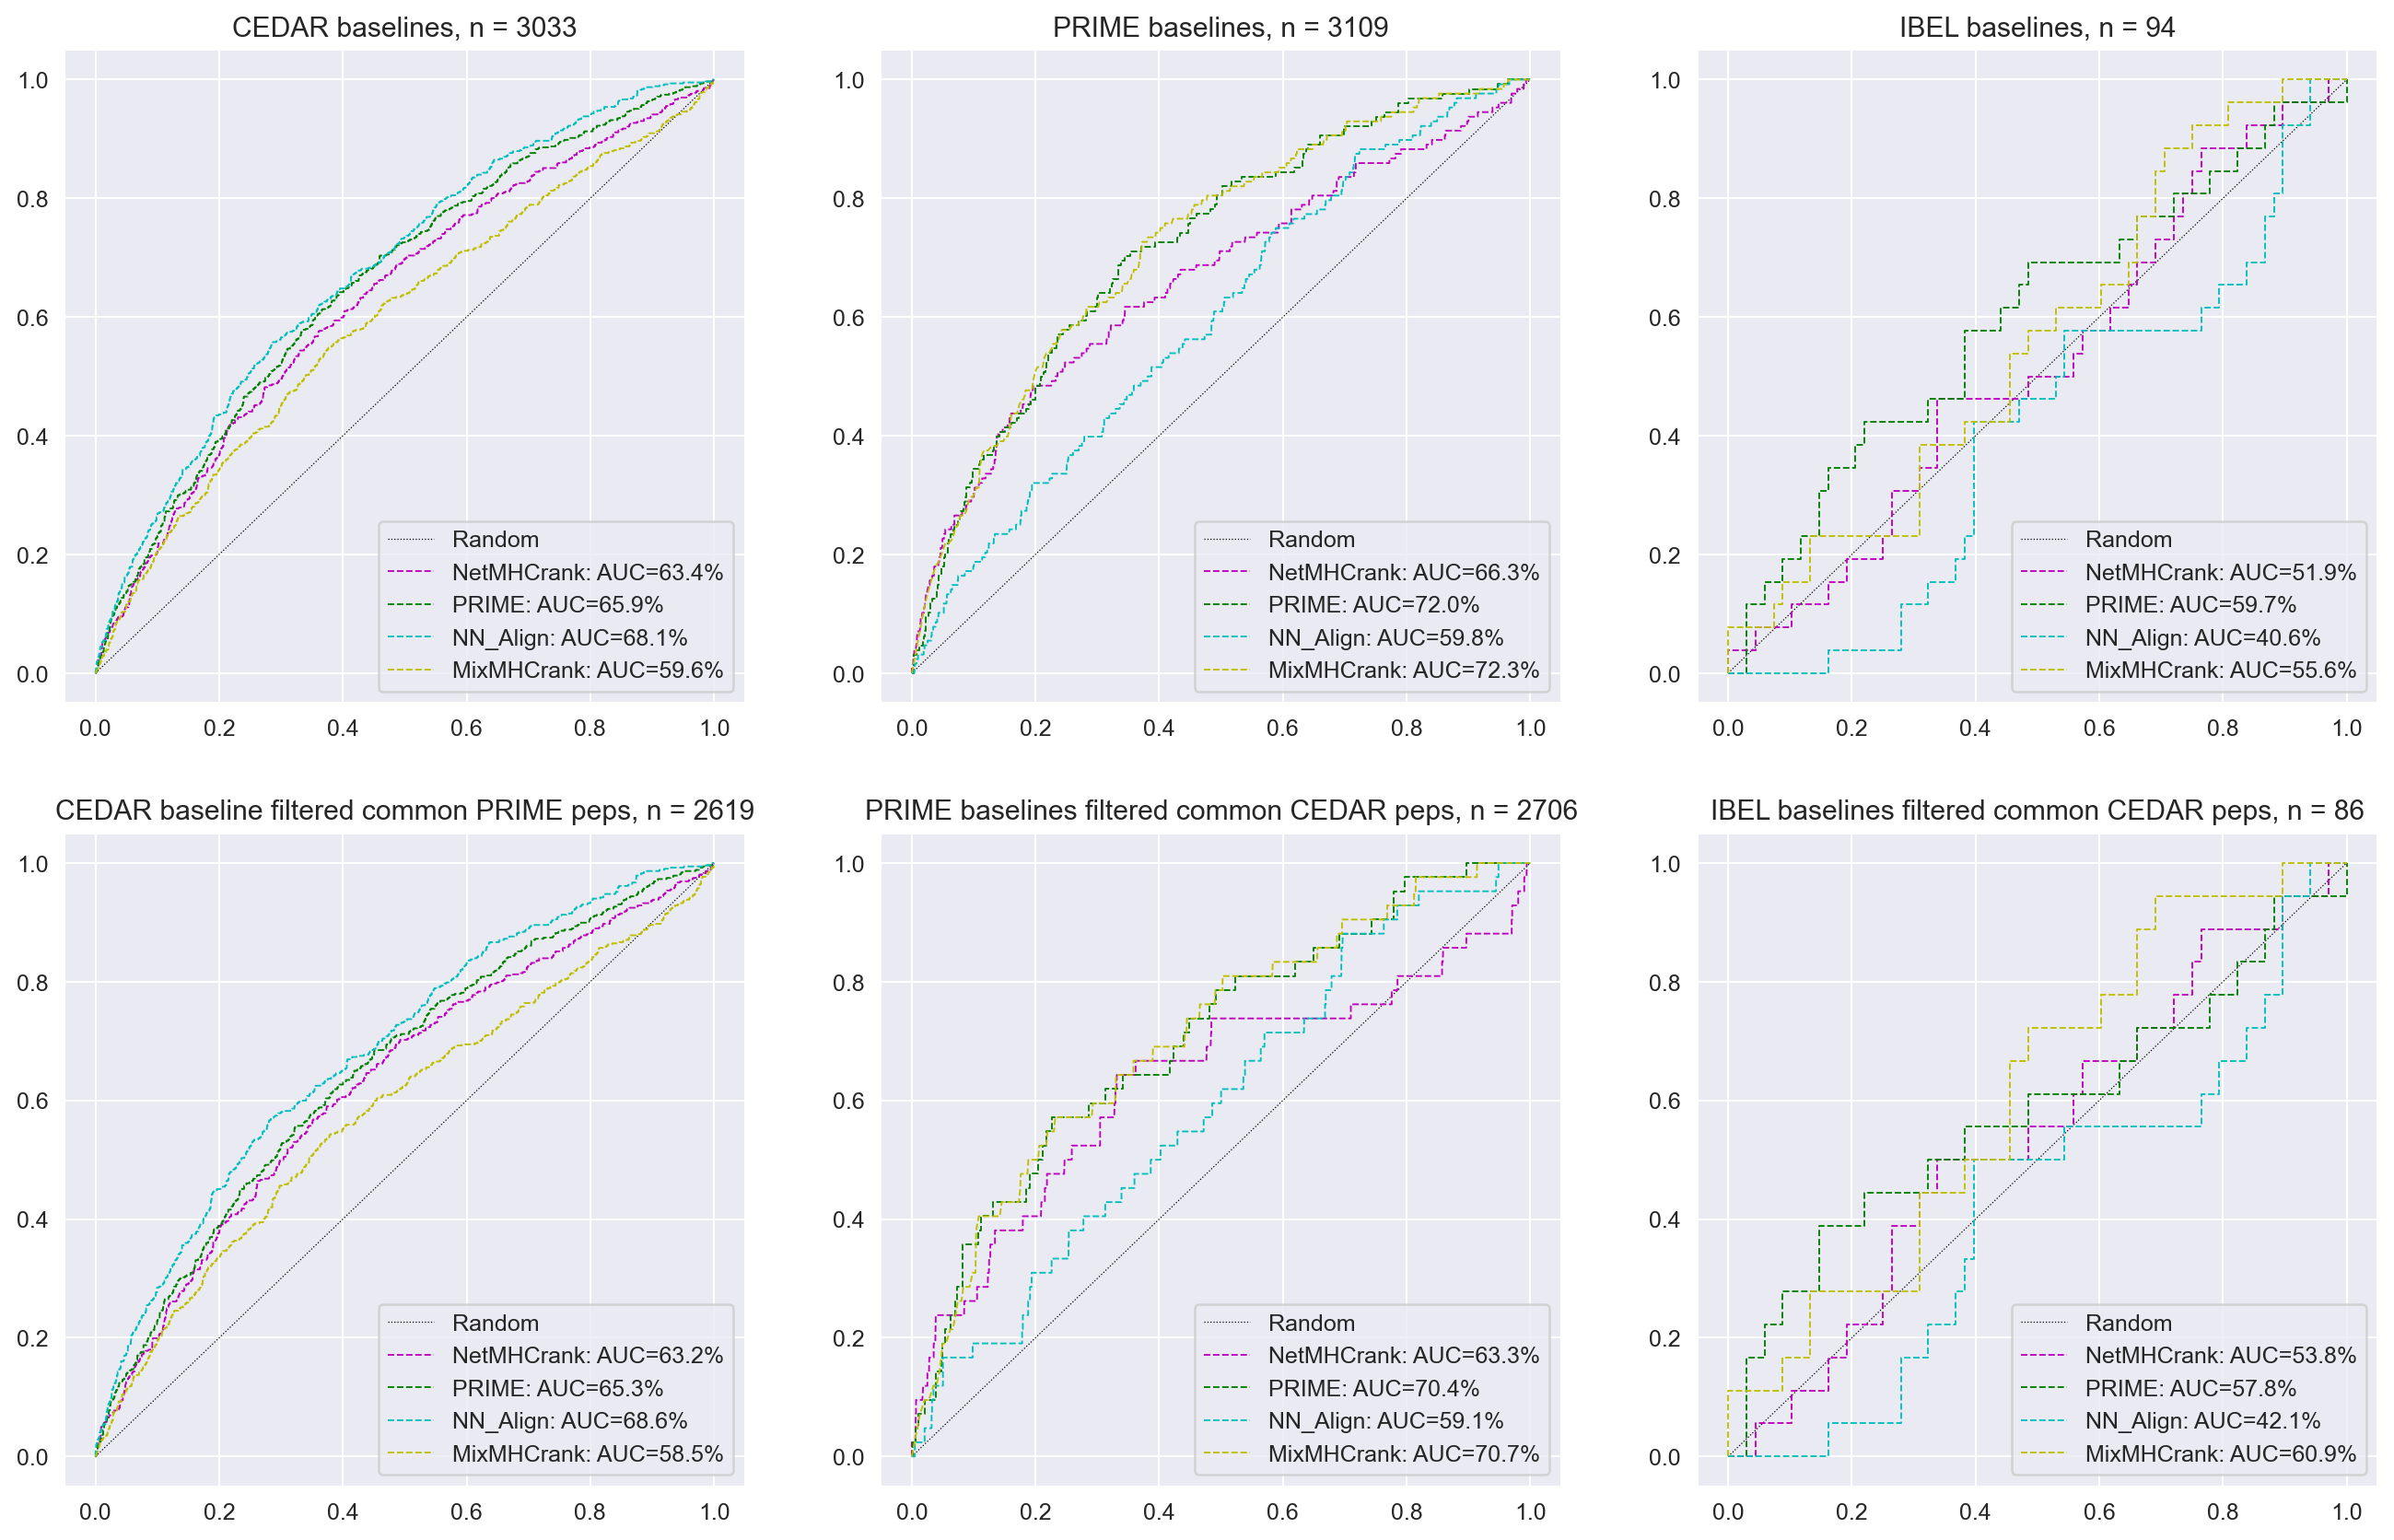

In [11]:
f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

In [12]:
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

0.5784313725490196

In [13]:
cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']

# Part 1 

Raw dataset stats (pos-neg ratios, hla ratios, anc-non anc, baseline with fullpep vs icore ranks)

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

In [15]:
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

## ranks AUC

### non filtered (CEDAR+rest)

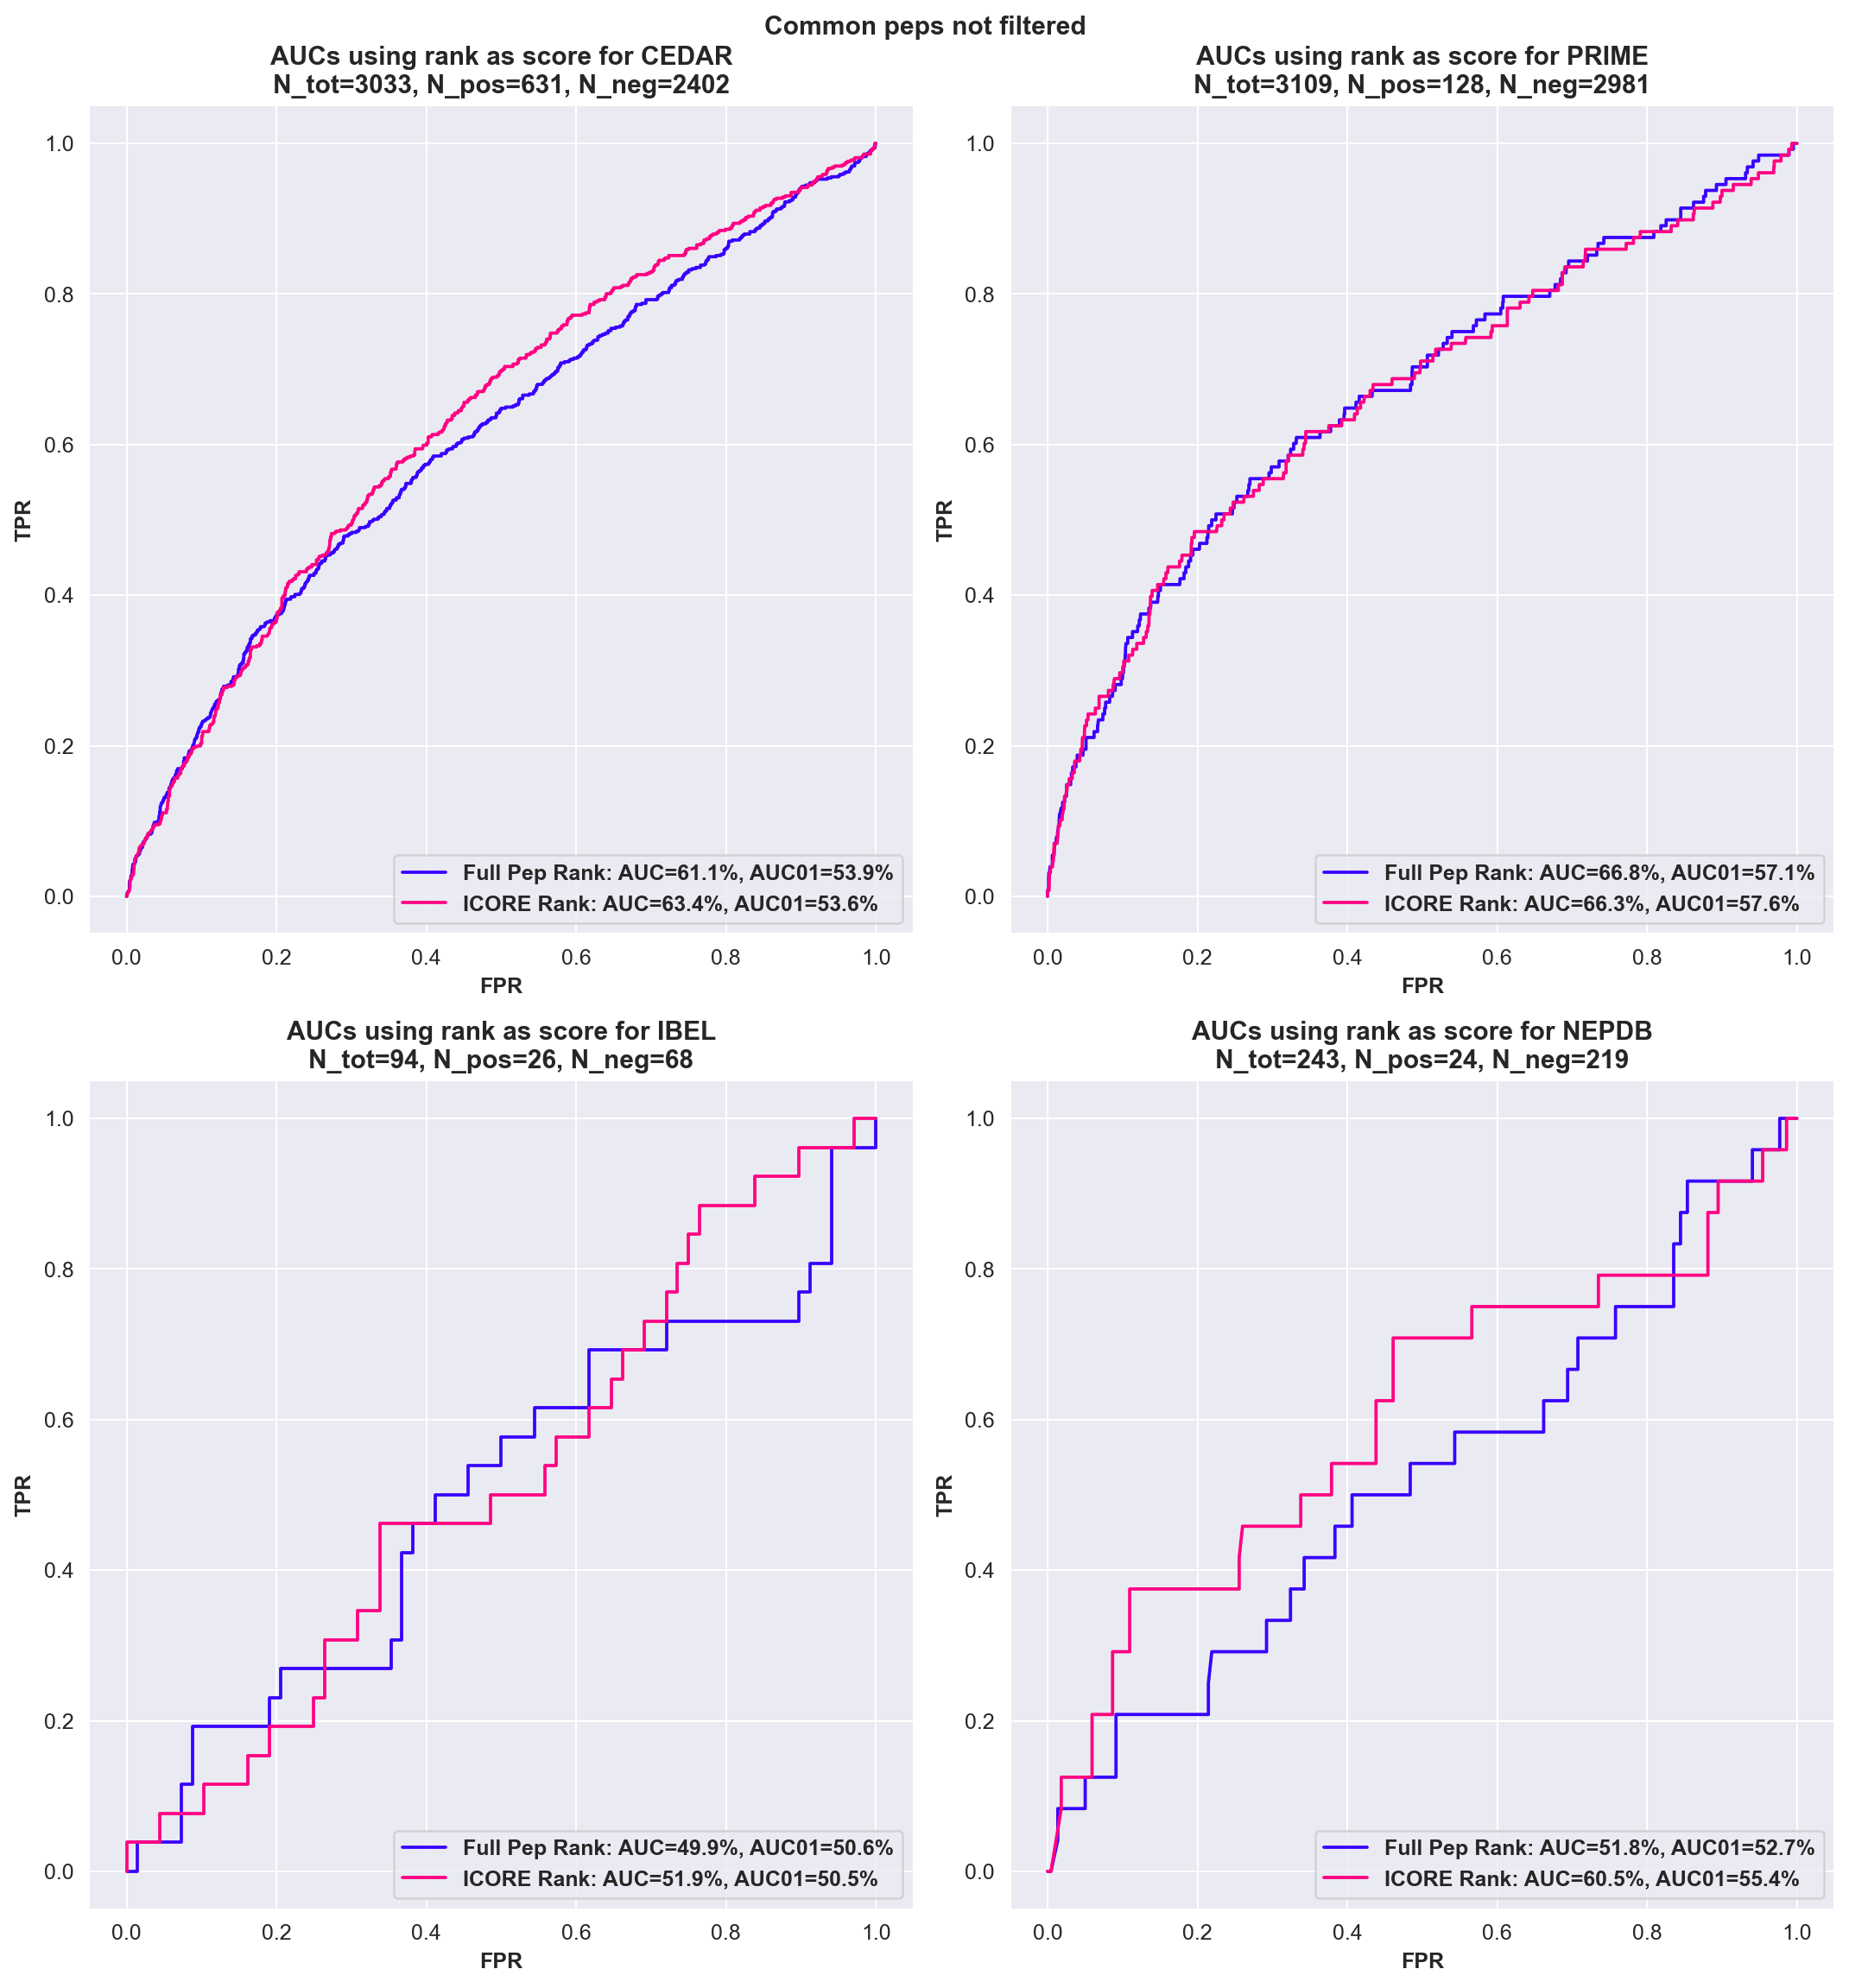

In [16]:
f,a = plt.subplots(2,2, figsize=(12,13))

for df, name, axis in zip([cedar_related, prime_related, ibel, nepdb],
                          ['CEDAR', 'PRIME', 'IBEL', 'NEPDB'],
                          a.ravel()):
    # full pep
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'trueHLA_EL_rank', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'Full Pep Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    # icore
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'EL_rank_mut', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'ICORE Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    n_pos = len(df.query('agg_label==1'))
    n_neg = len(df.query('agg_label==0'))
    n = len(df)
    axis.set_title(f'AUCs using rank as score for {name}\nN_tot={n}, N_pos={n_pos}, N_neg={n_neg}', fontweight='semibold')
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
f.suptitle('Common peps not filtered', fontweight='bold')
f.tight_layout()

### filtered common peps (CEDAR+rest)

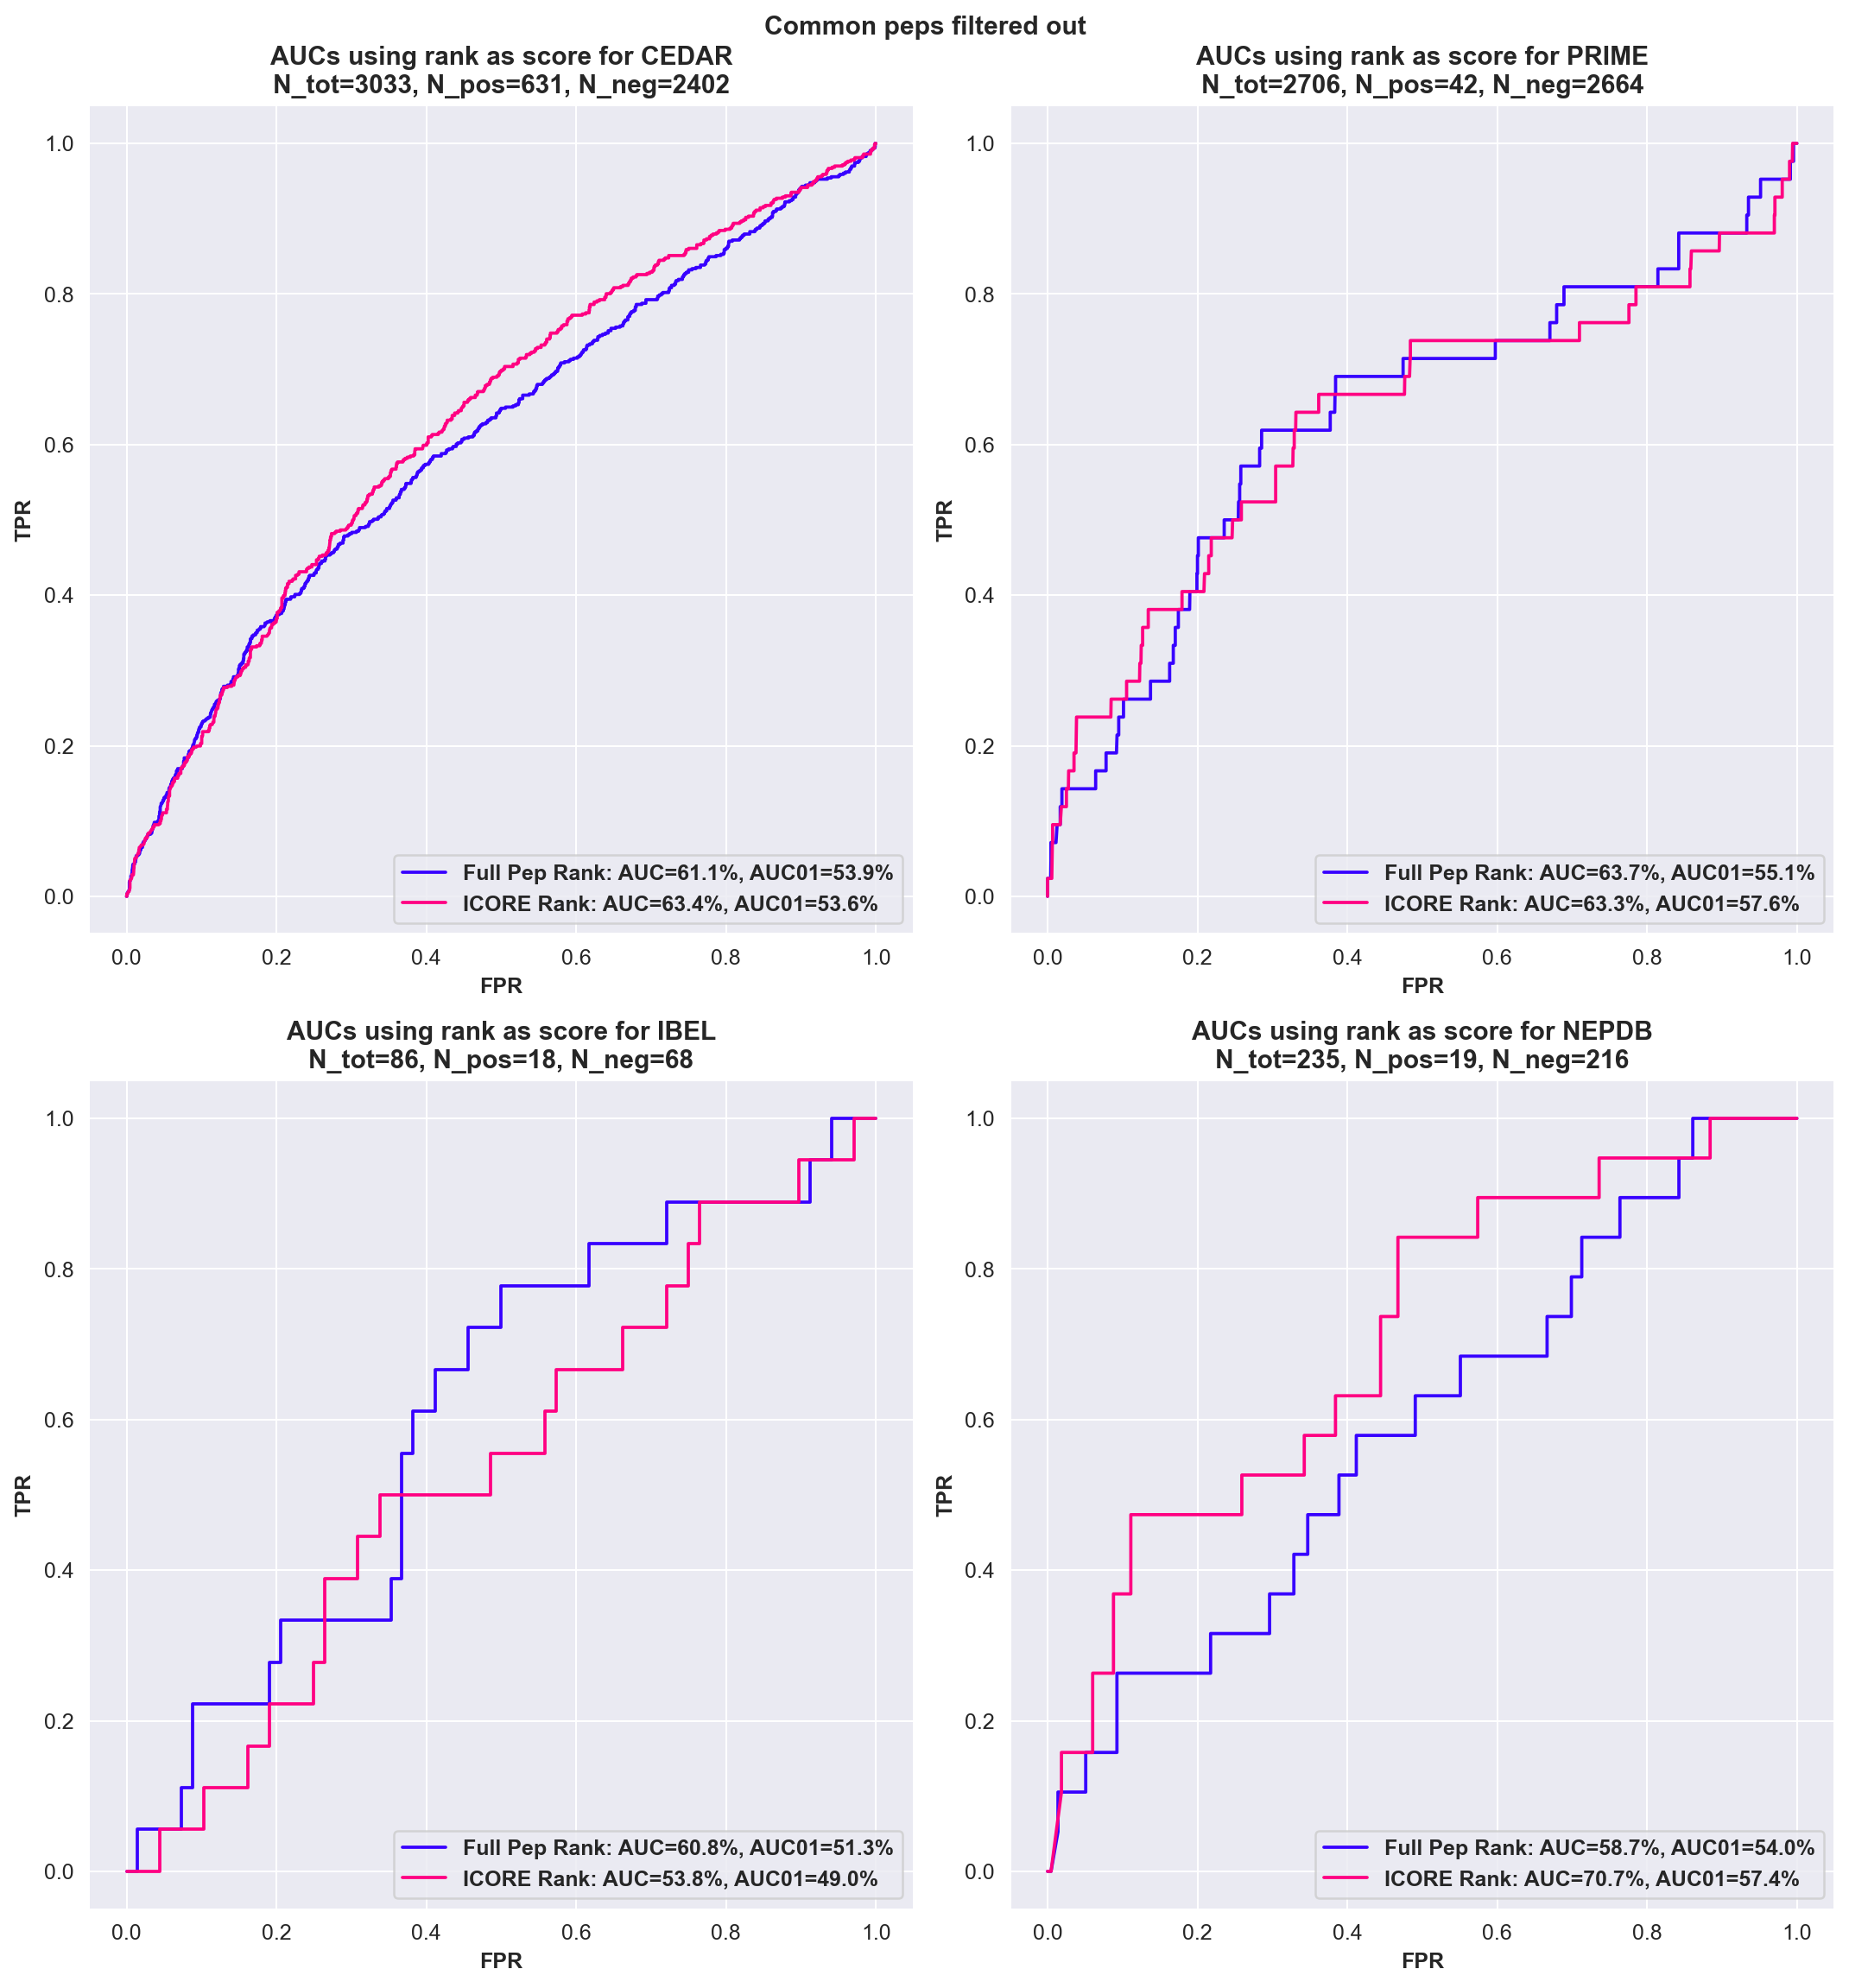

In [17]:
f,a = plt.subplots(2,2, figsize=(12,13))

for df, name, axis in zip([cedar_related, prime_related, ibel, nepdb],
                          ['CEDAR', 'PRIME', 'IBEL', 'NEPDB'],
                          a.ravel()):
    if name !='CEDAR':
        df = df.query('Peptide not in @cedar_related.Peptide.values')
    # full pep
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'trueHLA_EL_rank', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'Full Pep Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    # icore
    fpr, tpr, auc, auc01 = get_roc_curve_auc(df, 'agg_label', 'EL_rank_mut', neg=True)
    sns.lineplot(x=fpr, y=tpr, label = f'ICORE Rank: AUC={auc:.1%}, AUC01={auc01:.1%}', ax = axis, estimator=None)
    
    axis.legend(loc='lower right', prop=dict(weight='semibold'))
    n_pos = len(df.query('agg_label==1'))
    n_neg = len(df.query('agg_label==0'))
    n = len(df)
    axis.set_xlabel('FPR', fontweight='semibold')
    axis.set_ylabel('TPR', fontweight='semibold')
    axis.set_title(f'AUCs using rank as score for {name}\nN_tot={n}, N_pos={n_pos}, N_neg={n_neg}', fontweight='semibold')
f.suptitle('Common peps filtered out', fontweight='bold')
f.tight_layout()

## Anc-non anc, improved binder vs not ?